In [4]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
import import_ipynb
from util import utils

# 环境

In [5]:
env = utils.CartPoleEnv()

# 算法定义

## 策略网络

In [6]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

## 价值网络

### VNet

In [7]:
class VNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(VNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

### VAnet

In [8]:
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, 1)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q

## ActorCritic类

In [9]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device, name='AC'):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        if name == 'A2C':  # A2C采取不一样的网络框架
            self.critic = VAnet(state_dim, hidden_dim).to(device)  # 价值网络
        else:
            self.critic = VNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device
        self.name = name

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']),
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']),
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # 均方误差损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数

    def play(self, env, update=False, show=False):
        episode_return = 0
        transition_dict = {
            'states': [], 
            'actions': [], 
            'next_states': [], 
            'rewards': [], 
            'dones': []
        }
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done = env.step(action)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward
            if show:
                display.clear_output(wait=True)
                env.show()
        if update: 
            agent.update(transition_dict)
        return episode_return

# 初始化

In [10]:
torch.manual_seed(0)

In [11]:
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n
actor_lr = 1e-3
critic_lr = 1e-2
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
# name = 'AC'
name = 'A2C'
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device, name=name)

In [12]:
num_episodes = 1000
epochs = 10

# 玩一局游戏（训练前）

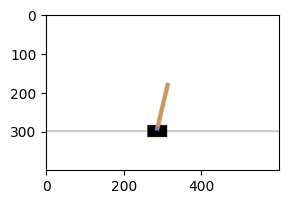

回报：21.0


In [13]:
episode_return = agent.play(env, update=False, show=True)
print("回报：{}".format(episode_return))

# 算法训练

## 训练过程

In [14]:
def train(env, agent, num_episodes, epochs):
    return_list = [] # 记录每一条序列的回报
    update = True
    show = False
    for i in range(epochs): # 显示epochs个进度条
        with tqdm(total=int(num_episodes / epochs), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / epochs)):  # 每个进度条的序列数
                episode_return = agent.play(env, update, show)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

In [15]:
return_list = train(env, agent, num_episodes=num_episodes, epochs=epochs)

Iteration 9: 100%|█████████████████████████████████████| 100/100 [02:07<00:00,  1.27s/it, episode=1000, return=459.700]


## 训练结果

### 训练回报

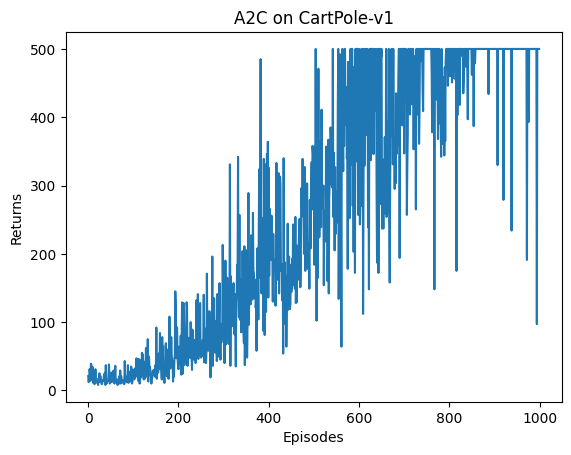

In [16]:
utils.show_return(return_list, agent, env)

### 移动平均训练回报

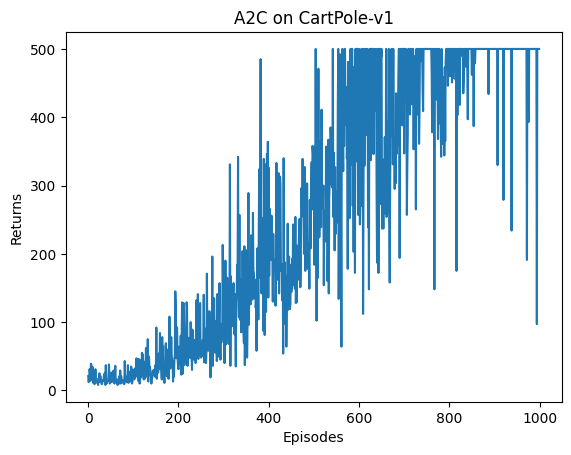

In [17]:
mv_return = utils.moving_average(return_list, 9)
utils.show_return(return_list, agent, env)

# 再玩一局游戏（训练后）

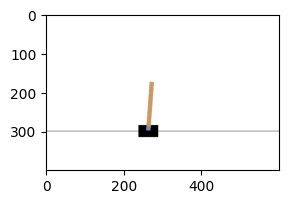

回报：500.0


In [18]:
episode_return = agent.play(env, update=False, show=True)
print("回报：{}".format(episode_return))